In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [14]:
from transformers import BertTokenizer, LxmertTokenizer
from data import ImageTextClassificationDataset, collate_fn_batch_visualbert, collate_fn_batch_lxmert, collate_fn_batch_visualbert_semi_supervised, collate_fn_batch_lxmert_semi_supervised
from matplotlib import pyplot as plt
import pandas as pd
from functools import partial
import torch
import os

In [3]:
# import argparse

In [4]:
# parser = argparse.ArgumentParser(description='train')
parser = pd.Series()
parser = parser.append(pd.Series({'img_feature_path': "../data/features/visualgenome/"}))
parser = parser.append(pd.Series({'train_csv_path': "../data/splits/random/memotion_train.csv"}))
parser = parser.append(pd.Series({'val_csv_path': "../data/splits/random/memotion_val.csv"}))
parser = parser.append(pd.Series({'model_type': "visualbert"}))
parser = parser.append(pd.Series({'model_path': "uclanlp/visualbert-vqa-coco-pre"}))
parser = parser.append(pd.Series({'learning_rate': 2e-5}))
parser = parser.append(pd.Series({'epoch': 100}))
parser = parser.append(pd.Series({'eval_step': 100}))
parser = parser.append(pd.Series({'batch_size': 64}))
parser = parser.append(pd.Series({'amp':True}))
parser = parser.append(pd.Series({'output_dir': "./tmp"}))
parser = parser.append(pd.Series({'checkpoint_step': 1000}))
parser = parser.append(pd.Series({'random_seed': 42}))
parser = parser.append(pd.Series({'resume_training': False}))
parser = parser.append(pd.Series({'semi_supervised': False}))


# args = parser.parse_args()
args = parser
args

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


img_feature_path              ../data/features/visualgenome/
train_csv_path      ../data/splits/random/memotion_train.csv
val_csv_path          ../data/splits/random/memotion_val.csv
model_type                                        visualbert
model_path                   uclanlp/visualbert-vqa-coco-pre
learning_rate                                        0.00002
epoch                                                    100
eval_step                                                100
batch_size                                                64
amp                                                     True
output_dir                                             ./tmp
checkpoint_step                                         1000
random_seed                                               42
resume_training                                        False
semi_supervised                                        False
dtype: object

In [5]:
img_feature_path = args.img_feature_path
model_type = args.model_type
# dataset_train = ImageTextClassificationDataset(img_feature_path, args.train_csv_path, 
#             supervise = not args.semi_supervised,model_type=model_type, vilt_processor=processor,mode='train')
dataset_train = ImageTextClassificationDataset(img_feature_path, args.val_csv_path, model_type=model_type,mode='train', 
                                                debug=True, metadata_path='../data/features/visualgenome/train_images/metadata.json'
                                                )


In [6]:
# load model
if model_type == "visualbert":
    # config = VisualBertConfig.from_pretrained(args.model_path)
    # model = VisualBertModel.from_pretrained(args.model_path)
    # model = ModelForBinaryClassification(model,config)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    # processor = None
elif model_type == "lxmert":
    # config = LxmertConfig.from_pretrained(args.model_path)
    # model = LxmertModel.from_pretrained(args.model_path)
    # model = ModelForBinaryClassification(model,config)
    tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased") 
    # processor = None
# elif model_type == "vilt":
#     from transformers import ViltProcessor, ViltModel, ViltForImagesAndTextClassification
#     config = AutoConfig.from_pretrained("dandelin/vilt-b32-mlm")
#     config.num_images = 1
#     model = ViltForImagesAndTextClassification(config)
#     model.vilt = ViltModel.from_pretrained(args.model_path)
#     processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
#     tokenizer = None

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
if args.semi_supervised:
    if model_type == "visualbert":
        collate_fn_batch = partial(collate_fn_batch_visualbert_semi_supervised,tokenizer=tokenizer)
    elif model_type == "lxmert":
        collate_fn_batch = partial(collate_fn_batch_lxmert_semi_supervised,tokenizer=tokenizer)
else:
    if model_type == "visualbert":
        collate_fn_batch = partial(collate_fn_batch_visualbert,tokenizer=tokenizer, debug=True)
    elif model_type == "lxmert":
        collate_fn_batch = partial(collate_fn_batch_lxmert,tokenizer=tokenizer)
    # elif model_type == "vilt":
    #     collate_fn_batch = partial(collate_fn_batch_vilt,processor=processor)

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    collate_fn = collate_fn_batch,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=3,)

In [9]:
batch_toks, batch_img_features, batch_labels, batch_metadata = next(iter(train_loader))

In [10]:
for caption_ids in batch_toks['input_ids'].tolist():
    print(tokenizer.convert_ids_to_tokens(caption_ids, skip_special_tokens=True))

['when', 'your', 'buddy', 'makes', 'a', 'great', 'joke', 'in', 'class', 'and', 'your', '##e', 'both', 'trying', 'not', 'to', 'laugh']
['when', 'i', 'catch', 'myself', 'stealing', 'money', 'from', 'my', 'savings', 'account']
['my', 'dude', 'is', 'washing', 'the', 'ground', 'in', 'the', 'rain', 'and', 'that', '##s', 'what', 'its', 'like', 'to', 'be', 'in', 'the', 'army']
['join', 'the', 'bog', '##o', 'resistance']
['when', 'she', 'reveals', 'a', 'bit', 'of', 'her', 'ankle', 'you', 'had', 'my', 'curiosity']
['when', 'you', 'rub', 'your', 'eyes', 'too', 'hard', 'and', 'get', 'transported', 'to', 'outer', 'space']
['smoke', '##s', 'candy', 'cigarette', 'cancer']
['how', 'companies', 'think', 'we', 'see', 'prices', '2000', '1999']
['got', 'to', 'work', 'with', 'the', 'c', 'success']
['650', '##0', 'year', 'old', 'soo', '##mer', '生', '口', 'ム', '##14', '加', '正']
['chess', 'me', '##mes', 'red', '##dit', 'people', 'who', 'don', '##t', 'know', 'how', 'to', 'play', 'chess']
['when', 'the', 'only',

In [11]:
batch_labels

tensor([[1, 0, 0, 0],
        [0, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1],
        [0, 0, 0, 0],
        [1, 1, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [0

In [12]:
batch_img_features.shape

torch.Size([64, 64, 2048])

In [13]:
batch_metadata

({'img_id': '1451.jpg',
  'img_h': 435,
  'img_w': 435,
  'objects_id': [71,
   71,
   234,
   71,
   71,
   71,
   71,
   71,
   71,
   540,
   51,
   51,
   540,
   71,
   50,
   50,
   50,
   242,
   50,
   71,
   632,
   234,
   364,
   50,
   364,
   540,
   632,
   540,
   191,
   632,
   242,
   71,
   71,
   90,
   50,
   191,
   1038,
   395,
   395,
   540,
   1038,
   372,
   540,
   1437,
   364,
   71,
   364,
   71,
   395,
   1251,
   1038,
   364,
   240,
   839,
   316,
   941,
   248,
   839,
   50,
   941,
   1437,
   839,
   956,
   71],
  'objects_conf': [0.8605374097824097,
   0.8551820516586304,
   0.8195148706436157,
   0.8103023171424866,
   0.7565945386886597,
   0.749573826789856,
   0.5713547468185425,
   0.5611559152603149,
   0.5574095845222473,
   0.5426861643791199,
   0.5090810060501099,
   0.5081249475479126,
   0.46811798214912415,
   0.4653136134147644,
   0.39789775013923645,
   0.3765866756439209,
   0.3676116168498993,
   0.34026777744293213,
   0

['when', 'your', 'buddy', 'makes', 'a', 'great', 'joke', 'in', 'class', 'and', 'your', '##e', 'both', 'trying', 'not', 'to', 'laugh']
['when', 'i', 'catch', 'myself', 'stealing', 'money', 'from', 'my', 'savings', 'account']
['my', 'dude', 'is', 'washing', 'the', 'ground', 'in', 'the', 'rain', 'and', 'that', '##s', 'what', 'its', 'like', 'to', 'be', 'in', 'the', 'army']
['join', 'the', 'bog', '##o', 'resistance']
['when', 'she', 'reveals', 'a', 'bit', 'of', 'her', 'ankle', 'you', 'had', 'my', 'curiosity']
['when', 'you', 'rub', 'your', 'eyes', 'too', 'hard', 'and', 'get', 'transported', 'to', 'outer', 'space']
['smoke', '##s', 'candy', 'cigarette', 'cancer']
['how', 'companies', 'think', 'we', 'see', 'prices', '2000', '1999']
['got', 'to', 'work', 'with', 'the', 'c', 'success']
['650', '##0', 'year', 'old', 'soo', '##mer', '生', '口', 'ム', '##14', '加', '正']
['chess', 'me', '##mes', 'red', '##dit', 'people', 'who', 'don', '##t', 'know', 'how', 'to', 'play', 'chess']
['when', 'the', 'only',

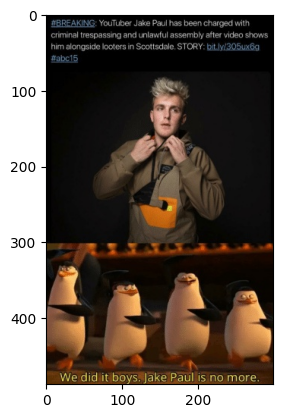

In [16]:
img_root_path = '../data/Memotion2.0/images/train_images'
batch_toks_ids = batch_toks['input_ids'].tolist()

for i in range(args.batch_size):
    sample_metadata = batch_metadata[i]
    sample_toks_ids = batch_toks_ids[i]
    
    img_path = os.path.join(img_root_path, sample_metadata['img_id'])
    img = plt.imread(img_path)
    
    sample_toks = tokenizer.convert_ids_to_tokens(sample_toks_ids, skip_special_tokens=True)

    print(sample_toks)
    plt.imshow(img)

    plt.show()